In [82]:
import re
import networkx as nx
import matplotlib.pyplot as plt
import heapq
from typing import List, Dict, Tuple
from datetime import datetime, timedelta

In [83]:
class ProjectScheduler:
    def __init__(self, file_path):
        self.data = {
            'projects': 0,
            'jobs': 0,
            'horizon': 0,
            'resources': {'renewable': 0, 'nonrenewable': 0},
            'precedence_relations': {},
            'job_details': {},
            'resource_availability': {}
        }
        try:
            self.parse_file(file_path)
            self.graph = self._create_graph()
        except Exception as e:
            print(f"Erro ao inicializar o ProjectScheduler: {str(e)}")
            raise
    
    def parse_file(self, file_path):
        try:
            with open(file_path, 'r') as file:
                content = file.read()
                
            # Parse general information
            sections = content.split('************************************************************************')
            
            # Parsing general information
            general_info = sections[1]
            projects_match = re.search(r'projects\s*:\s*(\d+)', general_info)
            jobs_match = re.search(r'jobs.*:\s*(\d+)', general_info)
            horizon_match = re.search(r'horizon\s*:\s*(\d+)', general_info)
            
            if not all([projects_match, jobs_match, horizon_match]):
                raise ValueError("Não foi possível encontrar informações gerais no arquivo")
            
            self.data['projects'] = int(projects_match.group(1))
            self.data['jobs'] = int(jobs_match.group(1))
            self.data['horizon'] = int(horizon_match.group(1))
            
            # Parse resources
            resources_match = re.search(r'- renewable\s*:\s*(\d+).*\n*.*- nonrenewable\s*:\s*(\d+)', general_info)
            if resources_match:
                self.data['resources']['renewable'] = int(resources_match.group(1))
                self.data['resources']['nonrenewable'] = int(resources_match.group(2))
            
            # Parse precedence relations
            precedence_section = None
            for section in sections:
                if '#Precedence relations' in section:
                    precedence_section = section
                    break
            
            if precedence_section:
                lines = precedence_section.strip().split('\n')
                for line in lines:
                    if line.strip() and not line.startswith('#'):
                        parts = line.split()
                        if len(parts) >= 4:  # job_nr, modes, num_successors, successors...
                            job_nr = int(parts[0])
                            successors = [int(x) for x in parts[3:]]
                            self.data['precedence_relations'][job_nr] = successors
            
            # Parse job details
            duration_section = None
            for section in sections:
                if '#Duration' in section:
                    duration_section = section
                    break
            
            if duration_section:
                lines = duration_section.strip().split('\n')
                for line in lines:
                    if line.strip() and not line.startswith('#'):
                        parts = line.split()
                        if len(parts) >= 4:  # job_nr, mode, duration, resources...
                            job_nr = int(parts[0])
                            duration = int(parts[2])
                            resources = {}
                            for i, resource_value in enumerate(parts[3:]):
                                resources[f'R{i+1}'] = int(resource_value)
                            self.data['job_details'][job_nr] = {
                                'duration': duration,
                                'resources': resources
                            }
            
            # Parse resource availability
            availability_section = None
            for section in sections:
                if '#Resource availability' in section:
                    availability_section = section
                    break
            
            if availability_section:
                lines = availability_section.strip().split('\n')
                for line in lines:
                    if line.strip() and not line.startswith('#'):
                        parts = line.split()
                        if len(parts) >= 2:
                            resource = parts[0]
                            quantity = int(parts[1])
                            self.data['resource_availability'][resource] = quantity
                            
        except FileNotFoundError:
            raise FileNotFoundError(f"Arquivo não encontrado: {file_path}")
        except Exception as e:
            raise Exception(f"Erro ao fazer parse do arquivo: {str(e)}")

    def _create_graph(self):
        """Cria um grafo direcionado baseado nas relações de precedência"""
        G = nx.DiGraph()
        
        # Adiciona nós com seus atributos
        for job_id, details in self.data['job_details'].items():
            G.add_node(job_id, **details)
        
        # Adiciona arestas baseadas nas relações de precedência
        for pred, successors in self.data['precedence_relations'].items():
            for succ in successors:
                G.add_edge(pred, succ)
                
        return G
    
    def get_project_summary(self):
        """Retorna um resumo do projeto"""
        return {
            'Total Projects': self.data['projects'],
            'Total Jobs': self.data['jobs'],
            'Time Horizon': self.data['horizon'],
            'Renewable Resources': self.data['resources']['renewable'],
            'Resource Availability': self.data['resource_availability']
        }
    
    def get_job_precedence(self):
        """Retorna as relações de precedência"""
        return self.data['precedence_relations']
    
    def get_job_details(self):
        """Retorna os detalhes das tarefas"""
        return self.data['job_details']

    def plot_precedence_graph(self):
        """Plota o grafo de precedência com layout melhorado"""
        try:
            # Configura o layout do grafo
            pos = nx.spring_layout(self.graph, k=0.5, iterations=50)
            
            # Criar nova figura
            plt.figure(figsize=(10, 6))
            
            # Desenha o grafo
            nx.draw(self.graph, pos, 
                    with_labels=True,
                    node_color='lightblue',
                    node_size=500,
                    arrows=True,
                    edge_color='gray',
                    font_size=10,
                    font_weight='bold')
            
            # Adiciona título
            plt.title("Grafo de Precedência de Tarefas")
            plt.show()
        except Exception as e:
            print(f"Erro ao plotar o grafo: {str(e)}")

    def plot_gantt_chart(self):
        """Plota um diagrama de Gantt básico"""
        try:
            # Calcula os early start times usando topological sort
            early_start = {node: 0 for node in self.graph.nodes()}
            for node in nx.topological_sort(self.graph):
                predecessors = list(self.graph.predecessors(node))
                if predecessors:
                    early_start[node] = max(early_start[p] + self.data['job_details'][p]['duration'] 
                                        for p in predecessors)

            # Configuração do plot
            fig, ax = plt.subplots(figsize=(15, 8))
            
            # Plota as barras para cada tarefa
            for i, task in enumerate(self.data['job_details'].keys()):
                start = early_start[task]
                duration = self.data['job_details'][task]['duration']
                ax.barh(i, duration, left=start, height=0.3, 
                       align='center', color='skyblue', alpha=0.8)
                
                # Adiciona o número da tarefa
                ax.text(start + duration/2, i, f'T{task}',
                       ha='center', va='center')

            # Configuração do layout
            ax.set_ylim(-1, len(self.data['job_details']))
            ax.set_xlabel('Tempo')
            ax.set_ylabel('Tarefas')
            ax.set_title('Diagrama de Gantt (Early Start Times)')
            ax.grid(True)
            
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Erro ao plotar o diagrama de Gantt: {str(e)}")

Resumo do Projeto:
{'Total Projects': 1, 'Total Jobs': 8, 'Time Horizon': 20, 'Renewable Resources': 2, 'Resource Availability': {'R1': 1, 'R2': 2}}

Relações de Precedência:
{1: [2, 3], 2: [4], 3: [4], 5: [6, 7], 6: [8], 7: [8]} 


Detalhes das Tarefas:
{1: {'duration': 2, 'resources': {'R1': 1, 'R2': 0}}, 2: {'duration': 3, 'resources': {'R1': 0, 'R2': 1}}, 3: {'duration': 4, 'resources': {'R1': 0, 'R2': 1}}, 4: {'duration': 1, 'resources': {'R1': 0, 'R2': 1}}, 5: {'duration': 2, 'resources': {'R1': 1, 'R2': 0}}, 6: {'duration': 3, 'resources': {'R1': 0, 'R2': 1}}, 7: {'duration': 4, 'resources': {'R1': 0, 'R2': 1}}, 8: {'duration': 1, 'resources': {'R1': 0, 'R2': 1}}}


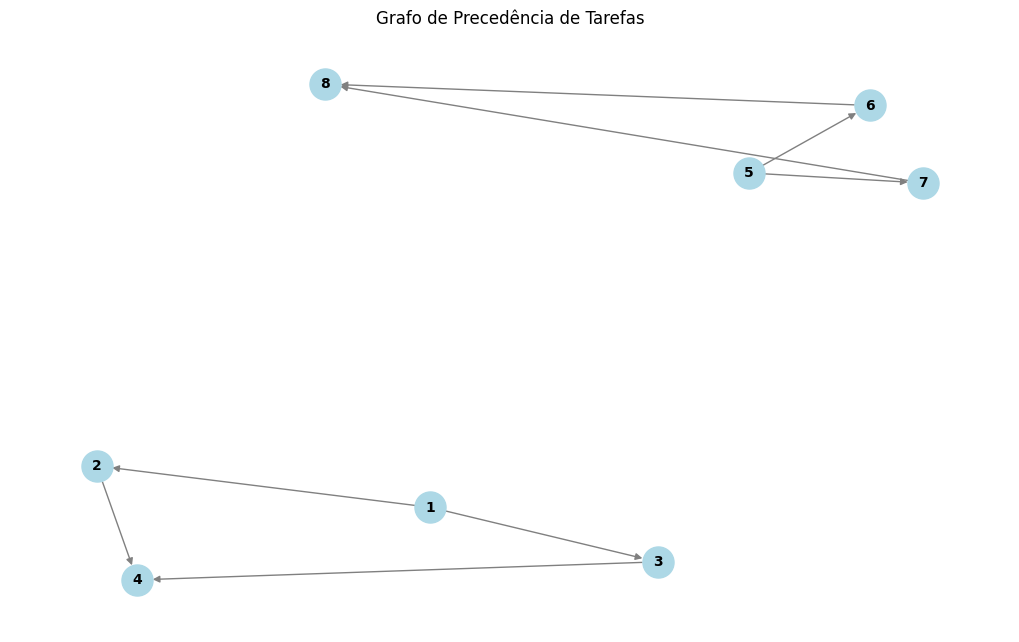

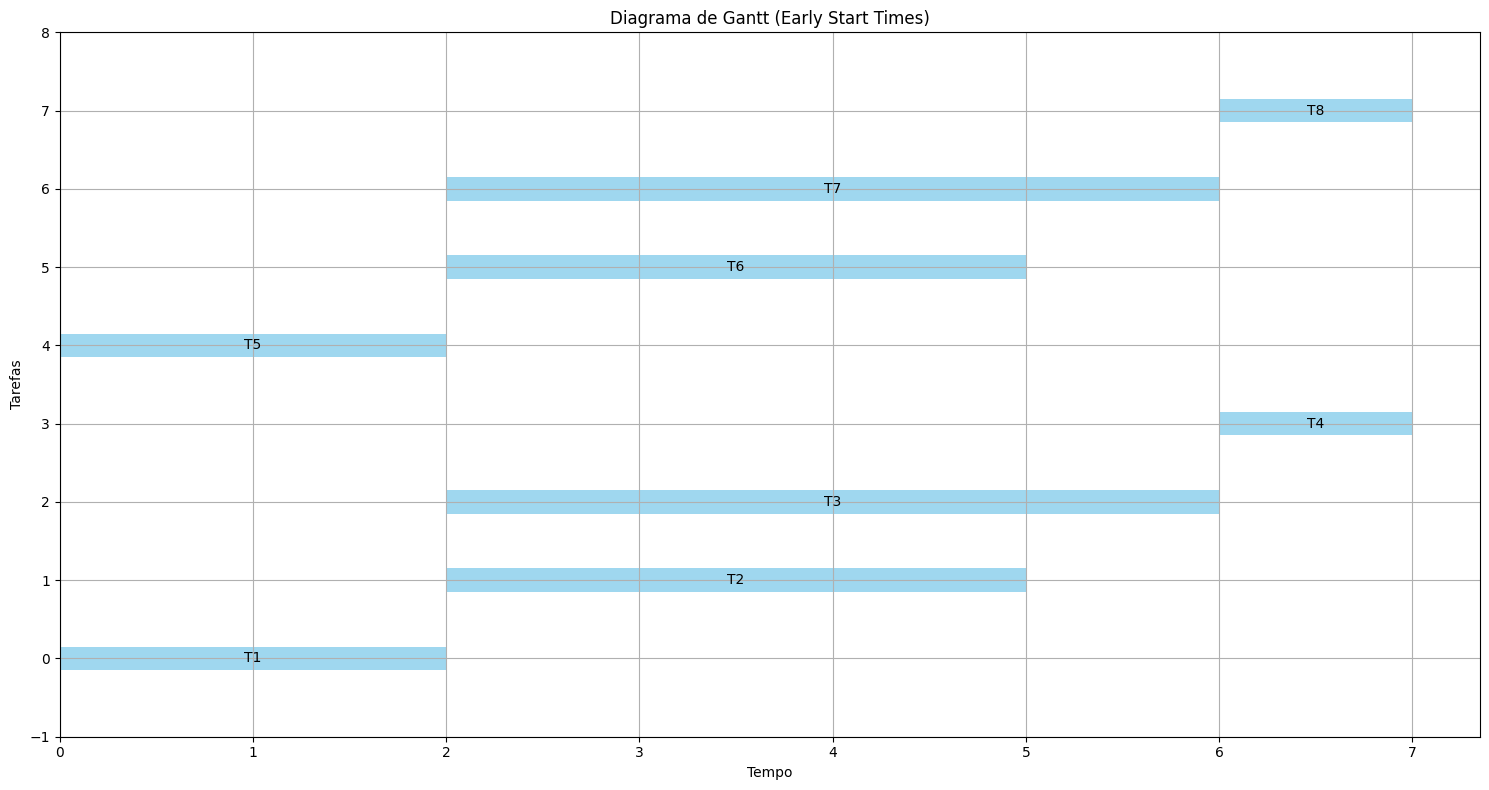

In [84]:
def main():
    try:
        # Caminho para o arquivo de configuração
        file_path = '8.txt'  # Ajuste o caminho conforme necessário

        # Cria uma instância do ProjectScheduler
        scheduler = ProjectScheduler(file_path)

        # Mostra resumo do projeto
        print("Resumo do Projeto:")
        print(scheduler.get_project_summary())

        # Mostra relações de precedência
        print("\nRelações de Precedência:")
        print(scheduler.get_job_precedence() , "\n")

        # Mostra detalhes das tarefas
        print("\nDetalhes das Tarefas:")
        print(scheduler.get_job_details())

        # Plota o grafo de precedência
        scheduler.plot_precedence_graph()

        # Plota o diagrama de Gantt
        scheduler.plot_gantt_chart()
        
    except Exception as e:
        print(f"Erro na execução do programa: {str(e)}")

if __name__ == "__main__":
    main()

Resumo do Projeto:
{'Total Projects': 1, 'Total Jobs': 12, 'Time Horizon': 46, 'Renewable Resources': 2, 'Resource Availability': {'R1': 6, 'R2': 4}}

Relações de Precedência:
{1: [2, 3, 4], 2: [5, 6], 3: [10, 11], 4: [9], 5: [7, 8], 6: [10, 11], 7: [9, 10], 8: [9], 9: [12], 10: [12], 11: [12]} 


Detalhes das Tarefas:
{1: {'duration': 0, 'resources': {'R1': 0, 'R2': 0}}, 2: {'duration': 3, 'resources': {'R1': 6, 'R2': 2}}, 3: {'duration': 1, 'resources': {'R1': 0, 'R2': 0}}, 4: {'duration': 8, 'resources': {'R1': 4, 'R2': 0}}, 5: {'duration': 4, 'resources': {'R1': 0, 'R2': 4}}, 6: {'duration': 4, 'resources': {'R1': 0, 'R2': 4}}, 7: {'duration': 6, 'resources': {'R1': 2, 'R2': 0}}, 8: {'duration': 4, 'resources': {'R1': 4, 'R2': 2}}, 9: {'duration': 5, 'resources': {'R1': 3, 'R2': 0}}, 10: {'duration': 7, 'resources': {'R1': 2, 'R2': 1}}, 11: {'duration': 4, 'resources': {'R1': 0, 'R2': 3}}, 12: {'duration': 0, 'resources': {'R1': 0, 'R2': 0}}}


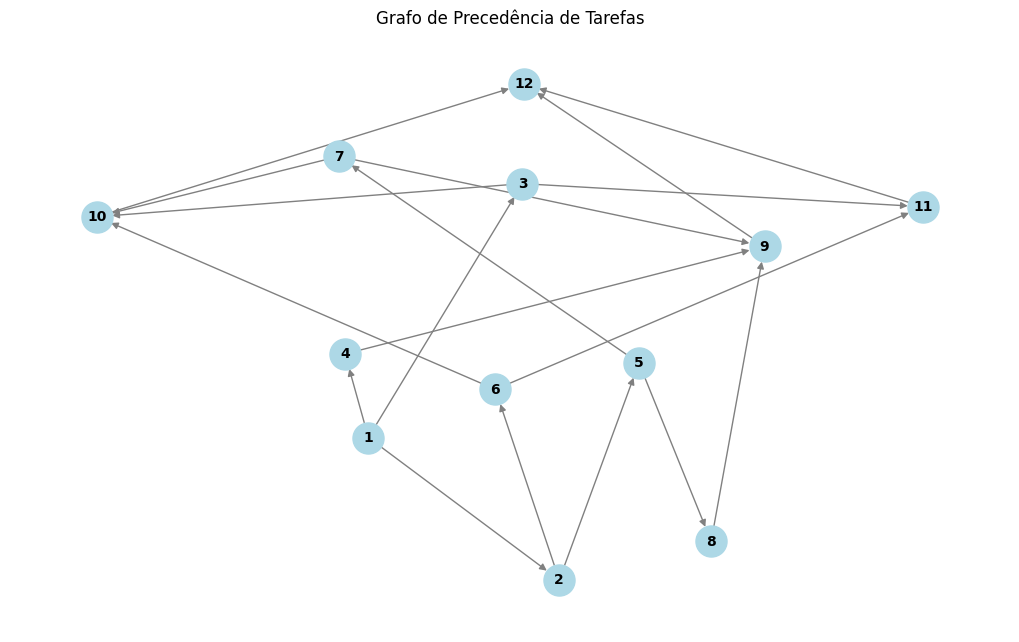

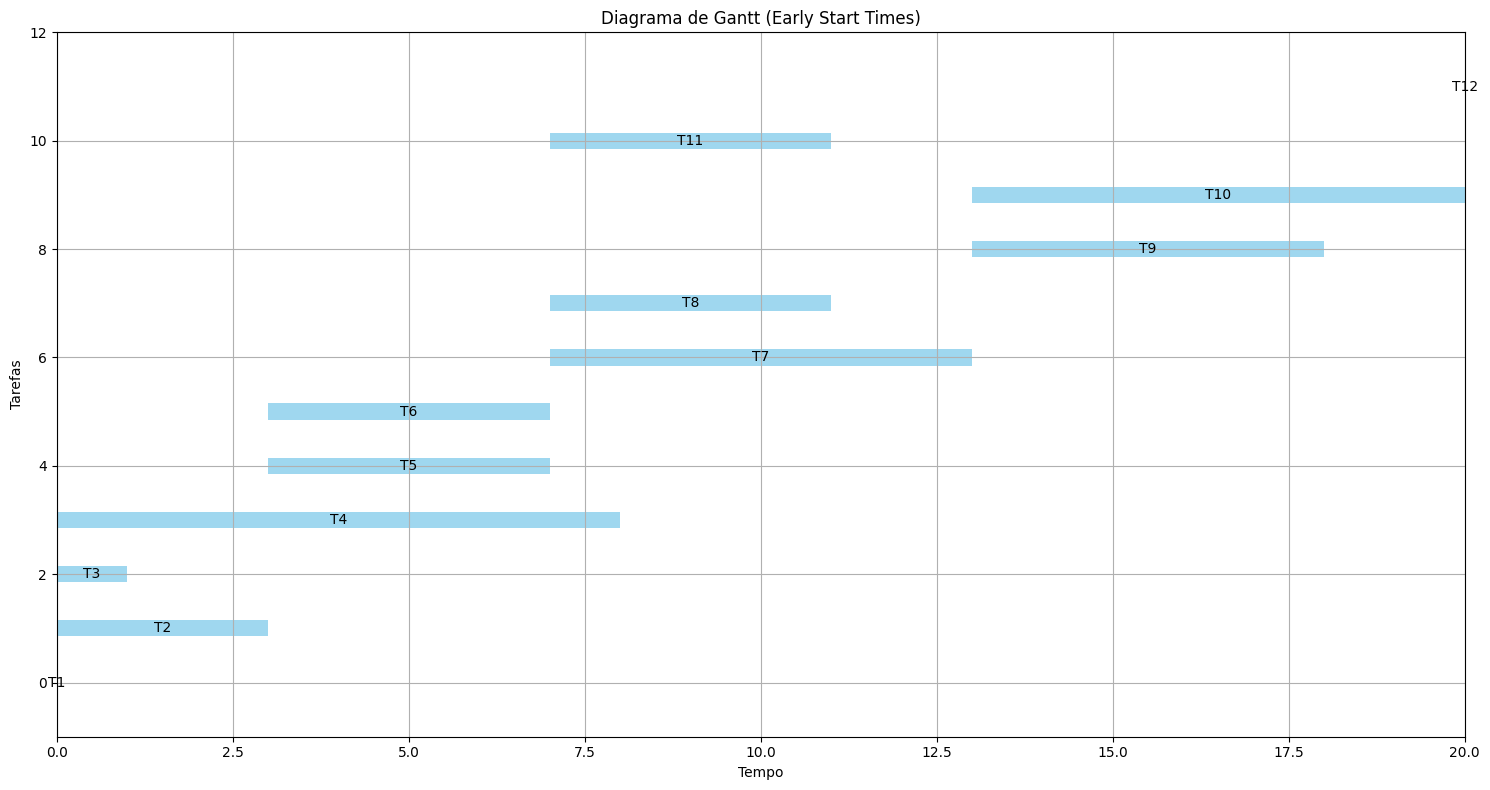

In [85]:
def main():
    try:
        # Caminho para o arquivo de configuração
        file_path = '10.txt'  # Ajuste o caminho conforme necessário

        # Cria uma instância do ProjectScheduler
        scheduler = ProjectScheduler(file_path)

        # Mostra resumo do projeto
        print("Resumo do Projeto:")
        print(scheduler.get_project_summary())

        # Mostra relações de precedência
        print("\nRelações de Precedência:")
        print(scheduler.get_job_precedence() , "\n")

        # Mostra detalhes das tarefas
        print("\nDetalhes das Tarefas:")
        print(scheduler.get_job_details())

        # Plota o grafo de precedência
        scheduler.plot_precedence_graph()

        # Plota o diagrama de Gantt
        scheduler.plot_gantt_chart()
        
    except Exception as e:
        print(f"Erro na execução do programa: {str(e)}")

if __name__ == "__main__":
    main()

Resumo do Projeto:
{'Total Projects': 1, 'Total Jobs': 32, 'Time Horizon': 141, 'Renewable Resources': 4, 'Resource Availability': {'R1': 10, 'R2': 8, 'R3': 13, 'R4': 12}}

Relações de Precedência:
{1: [2, 3, 4], 2: [23, 24], 3: [5, 6, 17], 4: [7, 20], 5: [10, 22, 28], 6: [18], 7: [8, 9, 12], 8: [14, 21, 27], 9: [11, 16], 10: [16], 11: [17], 12: [13, 15, 16], 13: [30], 14: [19], 15: [26], 16: [25], 17: [24], 18: [21], 19: [25], 20: [25, 27], 21: [22], 22: [29, 30], 23: [31], 24: [27], 25: [26], 26: [30], 27: [28], 28: [31], 29: [32], 30: [32], 31: [32]} 


Detalhes das Tarefas:
{1: {'duration': 0, 'resources': {'R1': 0, 'R2': 0, 'R3': 0, 'R4': 0}}, 2: {'duration': 1, 'resources': {'R1': 0, 'R2': 0, 'R3': 0, 'R4': 5}}, 3: {'duration': 1, 'resources': {'R1': 0, 'R2': 3, 'R3': 0, 'R4': 0}}, 4: {'duration': 1, 'resources': {'R1': 8, 'R2': 0, 'R3': 0, 'R4': 0}}, 5: {'duration': 7, 'resources': {'R1': 0, 'R2': 0, 'R3': 2, 'R4': 0}}, 6: {'duration': 6, 'resources': {'R1': 0, 'R2': 0, 'R3': 0,

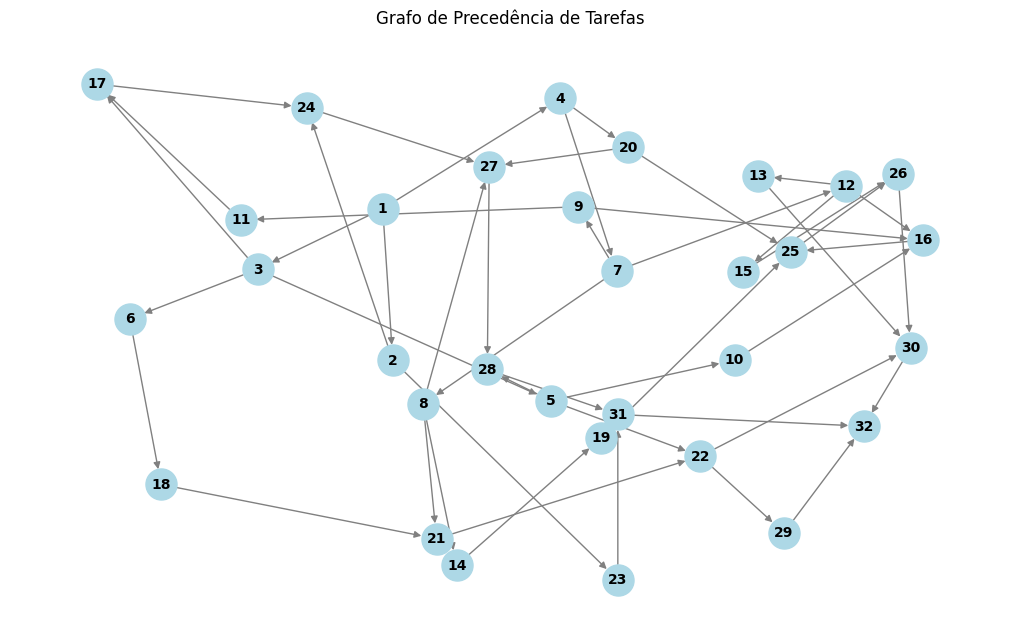

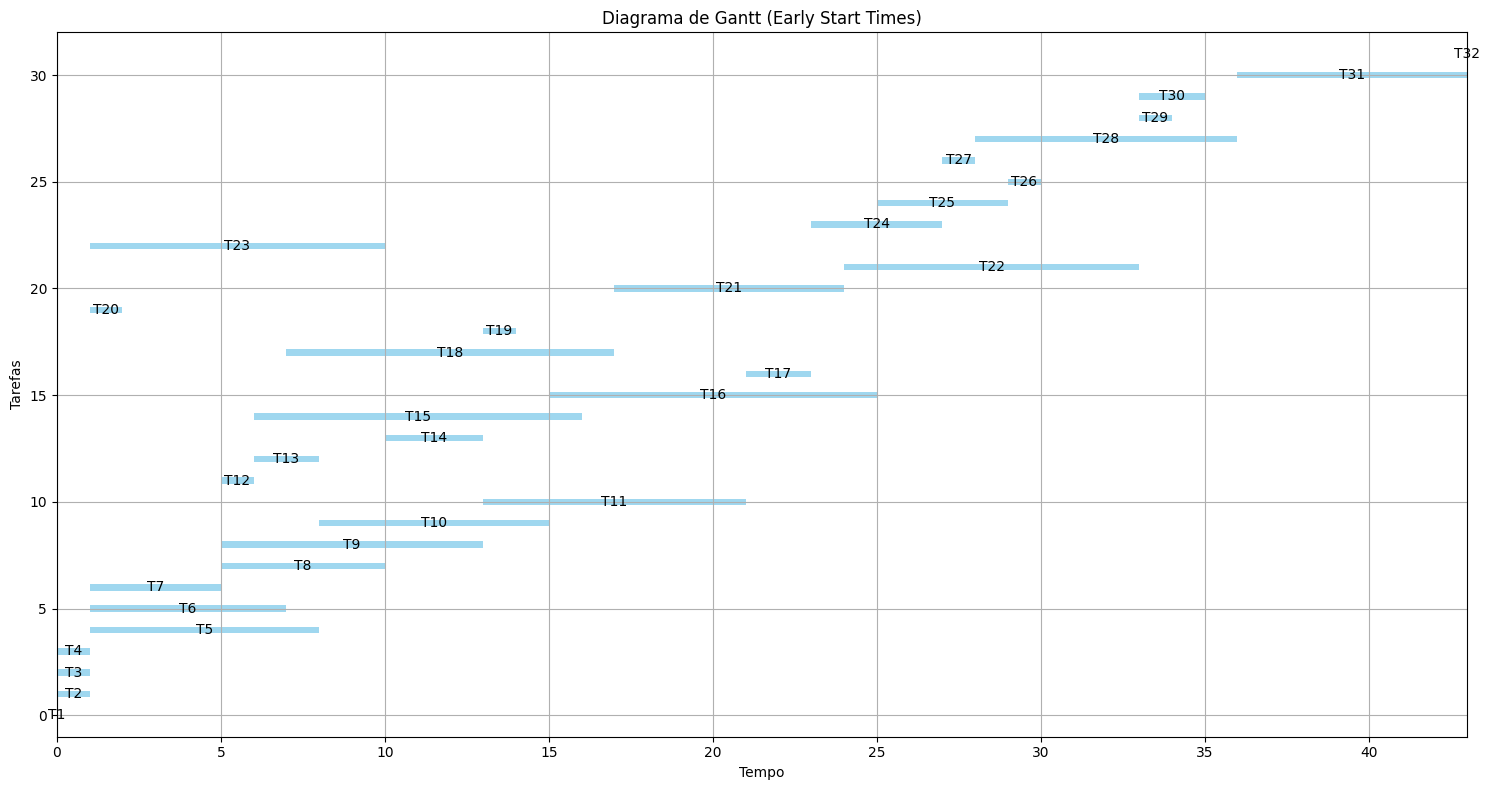

In [86]:
def main():
    try:
        # Caminho para o arquivo de configuração
        file_path = '30.txt'  # Ajuste o caminho conforme necessário

        # Cria uma instância do ProjectScheduler
        scheduler = ProjectScheduler(file_path)

        # Mostra resumo do projeto
        print("Resumo do Projeto:")
        print(scheduler.get_project_summary())

        # Mostra relações de precedência
        print("\nRelações de Precedência:")
        print(scheduler.get_job_precedence() , "\n")

        # Mostra detalhes das tarefas
        print("\nDetalhes das Tarefas:")
        print(scheduler.get_job_details())

        # Plota o grafo de precedência
        scheduler.plot_precedence_graph()

        # Plota o diagrama de Gantt
        scheduler.plot_gantt_chart()
        
    except Exception as e:
        print(f"Erro na execução do programa: {str(e)}")

if __name__ == "__main__":
    main()